In [4]:
# Importando bibliotecas

from os import mkdir, path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import datetime
import seaborn as sns


In [37]:
# Funções úteis

def dt_to_unix_ns(date):
    return datetime.datetime.timestamp(date) * 1000 * 1000

def unix_ns_to_dt(x):
    return pd.to_datetime(x, unit='us', origin='unix')

def kb_to_mb(x):
    return x / 1000

def truncate_microseconds(date):
    return date.replace(microsecond=0)

def extract_metric(api_url, metric, filename):
    response = requests.get(f'{api_url}/api/metrics?metric={metric}')

    with open(filename, mode='wb') as f:
        f.write(response.content)

def extract_node(api_url):
    response = requests.get(f'{api_url}/api/health')

    data = response.json()

    return data.get('node', 'no-node')

def extract_data(path, nodes):
    for api_url in api_urls:
        node = extract_node(api_url)

        nodes.append(node)

        for metric in metrics:
            extract_metric(api_url=api_url, metric=metric, filename=f'{path}/{node}-{metric}.csv')


def mkdir_if_not_exists(dir_path):
    if (not path.exists(dir_path)):
        mkdir(dir_path)

def read_metrics_data(path, filename, start_time, end_time):
    data = pd.read_csv(f'{path}/{filename}')

    data.columns = ['node', 'metric_name', 'label', 'measurement', 'time']

    data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    data['datetime'] = data['time'].apply(unix_ns_to_dt)

    data = data.set_index('datetime')

    return data

In [53]:
# Extraindo dados
scenario = 'cenario-1'
metrics = [
    'vm.memory.total',
    'vm.system_counts.process_count',
    'vm.system_counts.atom_count',
    'vm.system_counts.port_count',
    'events.total',
    'events.process_time',
    'mqtt.total',
    'mqtt.process_time'
]
api_urls = ['http://localhost:4001', 'http://localhost:4002', 'http://localhost:4003']


data_path = f'data/{scenario}'

mkdir_if_not_exists(data_path)

output_path = f'output/{scenario}'

mkdir_if_not_exists(output_path)

# nodes = ['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

nodes = []

extract_data(data_path, nodes)

nodes


['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

In [55]:
# Definindo data início e data fim da análise

start_date  = datetime.datetime(2022, 5, 18, 22, 00)
end_data  = datetime.datetime(2022, 5, 18, 22, 40)

start_date_in_unix_ns = dt_to_unix_ns(start_date)
end_date_in_unix_ns = dt_to_unix_ns(end_data)

In [56]:
# Sandbox
node = nodes[0]
metric = 'vm.memory.total'

data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

data['time'] = data['time'].apply(unix_ns_to_dt)
# data['measurement'] = data['measurement'].apply(kb_to_mb)

data = data.set_index('time')

data.head()

,node,metric_name,label,measurement
time,,,,
2022-05-19 01:38:50.570159,fogex@node-1,vm.memory.total,NaN,118492.344
2022-05-19 01:38:45.568888,fogex@node-1,vm.memory.total,NaN,119026.120
2022-05-19 01:38:40.567908,fogex@node-1,vm.memory.total,NaN,118885.152
2022-05-19 01:38:35.566945,fogex@node-1,vm.memory.total,NaN,118886.376
2022-05-19 01:38:30.565544,fogex@node-1,vm.memory.total,NaN,117231.576


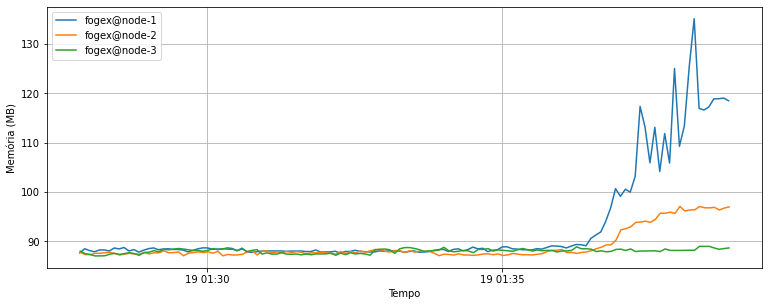

In [57]:
# Plotando a métrica vm.memory.total
datas = []
metric = 'vm.memory.total'

for node in nodes:
    data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

    data['measurement'] = data['measurement'].apply(kb_to_mb)

    datas.append((node, data))

ffig = plt.figure(figsize=(12.8, 4.8))

plt.ylabel('Memória (MB)')
plt.xlabel('Tempo')

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

plt.legend()
plt.grid()

plt.savefig(f'{output_path}/{metric}.png')

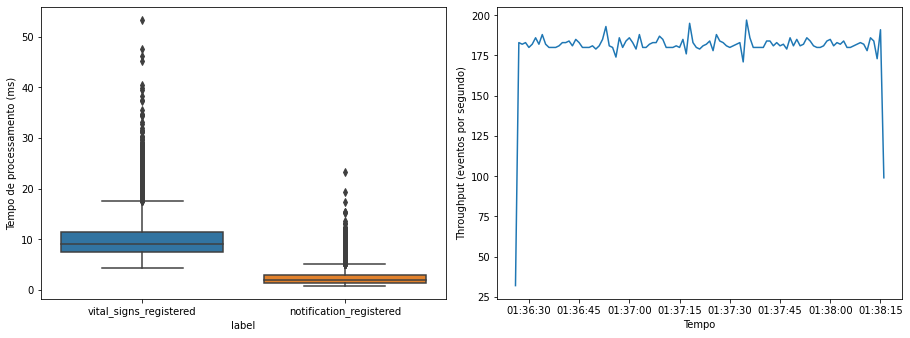

In [61]:
# Plotando a métrica events.process_time
datas = []
metric = 'events.process_time'

for node in nodes:
    try:
        data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        datas.append((node, data))
    except:
        continue

fig = plt.figure(figsize=(12.8, 4.8))

plt.subplot(1, 2, 1)

for (node, data) in datas:
    g = sns.boxplot(x=data['label'], y=data['measurement'], data=data)

    g.set_ylabel('Tempo de processamento (ms)')

# Plotando a métrica events.total
datas = []
metric = 'events.total'

for node in nodes:
    try:
        data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
        data['datetime in seconds'] = data['datetime in seconds'].apply(truncate_microseconds)

        groups = data.groupby('datetime in seconds')

        new_data = groups.aggregate(len)

        datas.append((node, new_data))
    except:
        continue

plt.subplot(1, 2, 2)

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

    plt.ylabel('Throughput (eventos por segundo)')
    plt.xlabel('Tempo')

plt.tight_layout()

plt.savefig(f'{output_path}/events.png')

plt.show()

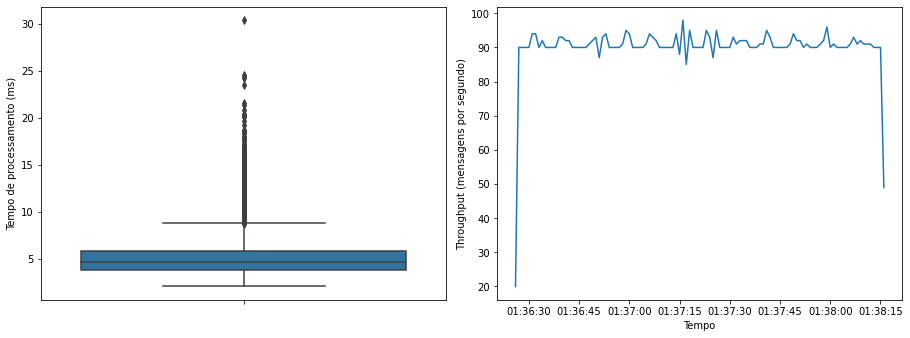

In [60]:
# Plotando a métrica mqtt.process_time
datas = []
metric = 'mqtt.process_time'

for node in nodes:
    try:
        data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        datas.append((node, data))
    except:
        continue

fig = plt.figure(figsize=(12.8, 4.8))

plt.subplot(1, 2, 1)

for (node, data) in datas:
    g = sns.boxplot(y=data['measurement'], data=data)

    g.set_ylabel('Tempo de processamento (ms)')

# Plotando a métrica mqtt.total
datas = []
metric = 'mqtt.total'

for node in nodes:
    try:
        data = read_metrics_data(data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
        data['datetime in seconds'] = data['datetime in seconds'].apply(truncate_microseconds)

        groups = data.groupby('datetime in seconds')

        new_data = groups.aggregate(len)

        datas.append((node, new_data))
    except:
        continue

plt.subplot(1, 2, 2)

for (node, data) in datas:
    plt.plot(data['measurement'], label=node)

    plt.ylabel('Throughput (mensagens por segundo)')
    plt.xlabel('Tempo')

plt.tight_layout()

plt.savefig(f'{output_path}/mqtt.png')

plt.show()